In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds


c:\Users\Dr. Ismail\Desktop\tf\TensorFlow-Notebooks\tf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


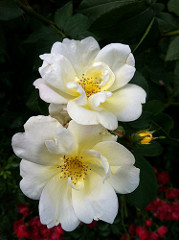

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

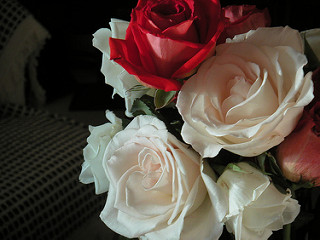

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    subset = "training",
    validation_split = 0.2,
    batch_size = batch_size,
    seed = 123,
    image_size = (img_height, img_width)
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [15]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [16]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


92/92 [==============================] - 74s 758ms/step - loss: 1.3400 - accuracy: 0.4094 - val_loss: 1.1183 - val_accuracy: 0.5123
Epoch 2/3
92/92 [==============================] - 89s 971ms/step - loss: 1.0515 - accuracy: 0.5777 - val_loss: 1.0514 - val_accuracy: 0.5722
Epoch 3/3
92/92 [==============================] - 92s 999ms/step - loss: 0.8844 - accuracy: 0.6597 - val_loss: 0.9863 - val_accuracy: 0.6185


In [17]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [18]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\Dr. Ismail\\.keras\\datasets\\flower_photos\\tulips\\17282288501_e8738c9cfb_n.jpg'
b'C:\\Users\\Dr. Ismail\\.keras\\datasets\\flower_photos\\daisy\\435283392_72e4c5b5d6_m.jpg'
b'C:\\Users\\Dr. Ismail\\.keras\\datasets\\flower_photos\\roses\\3661675690_ed2d05fa5f_n.jpg'
b'C:\\Users\\Dr. Ismail\\.keras\\datasets\\flower_photos\\roses\\7186509956_c37c02fb43_n.jpg'
b'C:\\Users\\Dr. Ismail\\.keras\\datasets\\flower_photos\\sunflowers\\14925397651_97dcddc383_n.jpg'


In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

In [19]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [20]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [21]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [22]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [23]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [24]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [25]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 79s 816ms/step - loss: 0.7813 - accuracy: 0.7003 - val_loss: 0.8099 - val_accuracy: 0.7003
Epoch 2/3
92/92 [==============================] - 64s 700ms/step - loss: 0.6046 - accuracy: 0.7725 - val_loss: 0.7536 - val_accuracy: 0.7248
Epoch 3/3
92/92 [==============================] - 55s 601ms/step - loss: 0.4240 - accuracy: 0.8460 - val_loss: 0.8463 - val_accuracy: 0.7098


In [26]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 100%|██████████| 1/1 [00:49<00:00, 49.22s/ url]


Dataset tf_flowers downloaded and prepared to C:\Users\Dr. Ismail\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [27]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)